In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import pandas as pd
import os
import shutil
import transformers
import torch.optim.lr_scheduler as lr_scheduler

from tqdm import tqdm
from torchsummary import summary
from sklearn.model_selection import train_test_split

/home/mehedi/anaconda3/envs/my-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SenDataset(torch.utils.data.Dataset):

	def __init__(self, run_type, feature_extractor):
		self.run_type = run_type
		self.feature_extractor = feature_extractor
		self.image_paths = []
		self.label_paths = []

	def setPaths(self, image_paths, label_paths):
		self.image_paths = image_paths

		# Guard
		if self.run_type != 'test':
			self.label_paths = label_paths

	def setImagePath(self, image_paths):
		self.image_paths = image_paths
	
	def importTif(self, path, gray: bool):
		image = cv2.imread(path)
		if gray:
			image = cv2.imread(path)[:,:,0]

		return image

	def __len__(self):
		return len(self.image_paths)

	def __getitem__(self, idx):

		if self.run_type != 'test':
			image = self.importTif(self.image_paths[idx], False)
			label = self.importTif(self.label_paths[idx], True)
			label = (label / 255).astype('uint8')
			encoded_inputs = self.feature_extractor(image, label, return_tensors='pt')
			for k,v in encoded_inputs.items():
				encoded_inputs[k].squeeze_()
			image = encoded_inputs['pixel_values']
			label = encoded_inputs['labels']

			return image, label

		else:
			image = self.importTif(self.image_paths[idx], False)
			encoded_inputs = self.feature_extractor(image, return_tensors='pt')
			for k,v in encoded_inputs.items():
				encoded_inputs[k].squeeze()

			image = encoded_inputs['pixel_values']
			return image, ''

def renameDataset():
	root_dir = os.path.join(os.getcwd(), "data")
	train_dir = os.path.join(root_dir, "train")

	paths = os.listdir(train_dir)
	paths = [os.path.join(train_dir, p) for p in paths]
	for p in paths:	
		
		image_path = os.path.join(p, "images")
		label_path = os.path.join(p, "labels")
		image_names = os.listdir(image_path)
		label_names = os.listdir(label_path)
		append_name = p.split('/')[-1]

		revised_image_names = [append_name + '_' + name for name in image_names]
		revised_label_names = [append_name + '_' + name for name in label_names]
		for iname, upiname in zip(image_names, revised_image_names):
			shutil.move(os.path.join(image_path, iname), os.path.join(image_path, upiname))
		for lname, uplname in zip(label_names, revised_label_names):
			shutil.move(os.path.join(label_path, lname), os.path.join(label_path, uplname))

def buildDataset(image_path: str, label_path:str, run_type: str):
	""" Populate the image and label arrays

	Args:
		root_dir (str): Path to root dir (where training or testing may take place)
		run_type (str): either 'train' or 'test'
	"""

	image_paths = []
	label_paths = []

	print('image_path: ', image_path)
	print('label_path: ', label_path)
	image_names = [os.path.join(image_path, name) for name in os.listdir(image_path)]
	image_paths.append(np.array(image_names))

	if run_type == 'train':
		label_names = [os.path.join(label_path, name) for name in os.listdir(label_path)]
		label_paths.append(np.array(label_names))
	
	image_paths = np.concatenate(image_paths)

	if run_type == 'train':
		label_paths = np.concatenate(label_paths)

	return image_paths, label_paths

In [3]:
def calcMeanAndStd():
	root_dir = os.path.join(os.getcwd(), "data")
	train_dir = os.path.join(root_dir, "train")

	paths = os.listdir(train_dir)
	paths = [os.path.join(train_dir, p) for p in paths]

	us = 0
	stds = 0
	its = 0
	for p in paths:	
		
		image_path = os.path.join(p, "images")
		image_names = os.listdir(image_path)

		for name in image_names:
			image = cv2.imread(os.path.join(image_path, name))
			image = cv2.resize(image, (512, 512))
			us = us + np.mean(image) 
			stds = stds + np.std(image) 
			its+=1

	print(us / float(its))
	print(stds / float(its))

In [4]:
train_images = "/home/pb/main_dataset_v2/train/images"
train_lables = "/home/pb/main_dataset_v2/train/labels"
test_images = "/home/pb/main_dataset_v2/test/images"
test_labels = "/home/pb/main_dataset_v2/test/labels"

Xtr, Ytr = buildDataset(train_images,train_lables, 'train')
print(f"Xtr.shape: {Xtr.shape} Ytr.shape: {Ytr.shape}")

Xte, _ = buildDataset(test_images,test_labels, 'test')
print(f"Xte.shape: {Xte.shape}")

image_path:  /home/mehedi/Projects/Learning/segfoer/main_dataset_v2/train/images
label_path:  /home/mehedi/Projects/Learning/segfoer/main_dataset_v2/train/labels
Xtr.shape: (2757,) Ytr.shape: (2757,)
image_path:  /home/mehedi/Projects/Learning/segfoer/main_dataset_v2/test/images
label_path:  /home/mehedi/Projects/Learning/segfoer/main_dataset_v2/test/labels
Xte.shape: (307,)


In [5]:
a = np.array([x.split('.')[0].split('/')[-1] for x in Xtr])
b = np.array([y.split('.')[0].split('/')[-1] for y in Ytr])

c = np.where(np.intersect1d(a, b))
Xtr = Xtr[c]

In [6]:
Xtr, Xval, Ytr, Yval = train_test_split(Xtr, Ytr, test_size=0.2, shuffle=True)
print(f"Xtr: {Xtr.shape}, Ytr: {Ytr.shape}")
print(f"Xval: {Xval.shape}, Yval: {Yval.shape}")

Xtr: (2205,), Ytr: (2205,)
Xval: (552,), Yval: (552,)


In [7]:
image_mean = 103.84
image_std = 7.92

feature_extractor_train = transformers.SegformerImageProcessor()
feature_extractor_test = transformers.SegformerImageProcessor(do_normalize=False)

trds = SenDataset('train', feature_extractor_train)
trds.setPaths(Xtr, Ytr)

valds = SenDataset('validation', feature_extractor_train)
valds.setPaths(Xval, Yval)

teds = SenDataset('test', feature_extractor_test)
teds.setImagePath(Xte)
batch_size = 8

train_loader = torch.utils.data.DataLoader(trds, batch_size=batch_size, num_workers=8)
valid_loader = torch.utils.data.DataLoader(valds, batch_size=batch_size, num_workers=4)
test_loader = torch.utils.data.DataLoader(teds, batch_size=1)

2024-09-28 02:51:09.987306: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-28 02:51:10.175591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-28 02:51:10.273470: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-28 02:51:10.298501: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-28 02:51:10.453573: I tensorflow/core/platform/cpu_feature_guar

Image Size: torch.Size([3, 512, 512])
Label Size: torch.Size([512, 512])
Unique Label Values: [0 1]


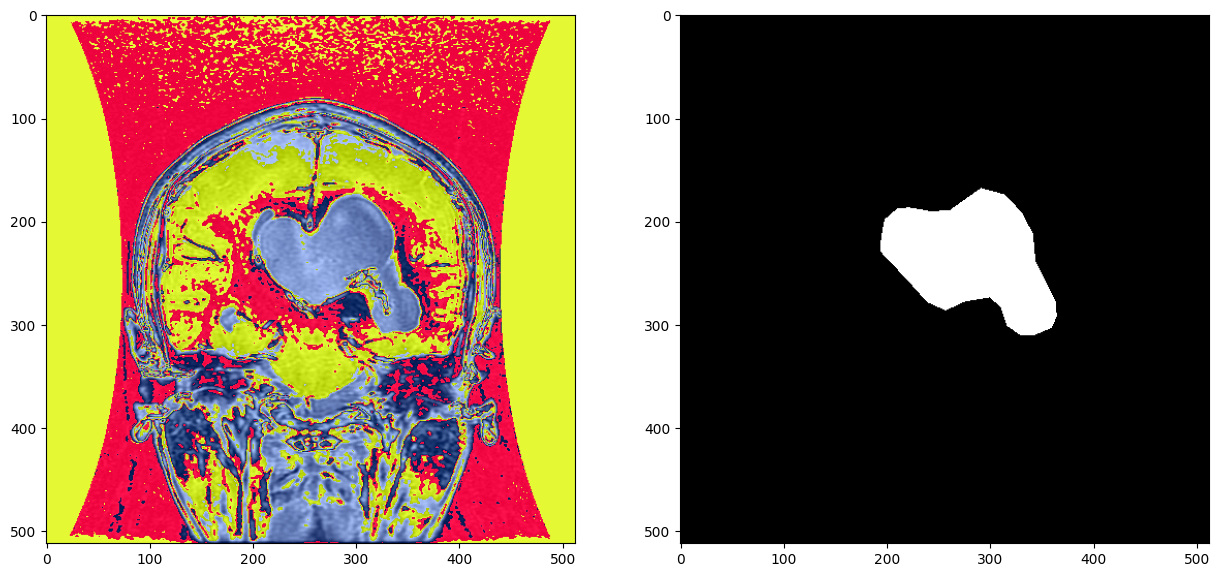

In [8]:
image, label = trds.__getitem__(1)

print(f"Image Size: {image.shape}")
print(f"Label Size: {label.shape}")

image = image.numpy()
label = label.numpy()

print(f"Unique Label Values: {np.unique(label)}") 
image = np.moveaxis(image, 0, -1)
image = (image * 255).astype('uint8')

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(image)
ax[1].imshow(label, cmap='gray')
plt.show()

In [9]:
class DiceLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        logits = torch.sigmoid(inputs)       
        sig = torch.sigmoid(logits)
        softmax = F.softmax(sig, dim=1)
        probs, _ = torch.max(softmax, dim=1)
        intersection = (probs * targets).sum()
        dice = (2. * intersection + 1) / (probs.sum() + targets.sum() + 1)
        
        return 1 - dice


class WeightedCE(torch.nn.Module):
    def __init__(self, weights):
        super(WeightedCE, self).__init__()
        self.weights = weights
        self.criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weights[1]))

    def forward(self, logits, targets):
        sig = torch.sigmoid(logits)
        softmax = F.softmax(logits, dim=1)
        probs, _ = torch.max(softmax, dim=1)

        probs = probs.flatten()
        targets = torch.flatten(targets)

        loss = (-1 * self.weights[1] * targets * torch.log(probs)) - (self.weights[0] * (1 - targets) * torch.log(1 - targets))
        return torch.mean(loss)

In [10]:
class SegFormerCustom(transformers.SegformerPreTrainedModel):
	def __init__(self, config, pretrained):
		super().__init__(config)
		self.segformer = transformers.SegformerForSemanticSegmentation.from_pretrained(pretrained, num_labels=config.num_labels)
		self.pretrained_path = pretrained
		self.num_labels = config.num_labels

	def forward(self, pixel_values, labels=None):
		outputs = self.segformer(pixel_values, labels)
		return outputs.logits, outputs.loss

In [11]:
config = transformers.SegformerConfig(num_labels=1) 
model = SegFormerCustom(config, 'nvidia/mit-b0')

/home/mehedi/anaconda3/envs/my-env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.running_var', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm.bias', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.0.proj.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.bias', 'decode_head.batch_norm.weight', 'decode_head.linear_c.1.proj.weight', 'decode_

In [12]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' 
model = model.to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=0.000006)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)

In [13]:
total_steps = len(train_loader)
epochs = 150

train_loss_avg = []
val_loss_avg = []

for ep in range(epochs):

    per_epoch_loss_train = []
    per_epoch_loss_val = []

    for idx, (images, masks) in enumerate(tqdm(train_loader)):
        images = images.float().to(device)
        masks = masks.type(torch.LongTensor).to(device)

        output = model(pixel_values=images, labels=masks)
        loss = output[1]
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        per_epoch_loss_train.append(loss.item())

    print(f"Epoch: {ep}: Training Loss: {np.mean(np.array(per_epoch_loss_train))}")

    for idx, (images, masks) in enumerate(tqdm(valid_loader)):
        images = images.float().to(device)
        masks = masks.type(torch.LongTensor).to(device)

        output = model(pixel_values=images, labels=masks)
        loss = output[1]

        per_epoch_loss_val.append(loss.item())
    print(f"Epoch: {ep}: Validation Loss: {np.mean(np.array(per_epoch_loss_val))}")

    scheduler.step()
    
    train_loss_avg.append(np.mean(np.array(per_epoch_loss_train)))
    val_loss_avg.append(np.mean(np.array(per_epoch_loss_val)))

100%|██████████| 276/276 [01:28<00:00,  3.12it/s]


Epoch: 0: Training Loss: 0.20294144225941188


100%|██████████| 69/69 [00:06<00:00, 10.00it/s]


Epoch: 0: Validation Loss: 0.08067827952512796


100%|██████████| 276/276 [01:27<00:00,  3.14it/s]


Epoch: 1: Training Loss: 0.059971001167930124


100%|██████████| 69/69 [00:06<00:00,  9.90it/s]


Epoch: 1: Validation Loss: 0.042118166316894516


100%|██████████| 276/276 [01:25<00:00,  3.25it/s]


Epoch: 2: Training Loss: 0.036989637090406126


100%|██████████| 69/69 [00:06<00:00, 10.57it/s]


Epoch: 2: Validation Loss: 0.0322819113785374


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 3: Training Loss: 0.02938556838510693


100%|██████████| 69/69 [00:06<00:00, 10.78it/s]


Epoch: 3: Validation Loss: 0.026990084517477215


100%|██████████| 276/276 [01:22<00:00,  3.34it/s]


Epoch: 4: Training Loss: 0.025265278966179576


100%|██████████| 69/69 [00:06<00:00, 10.88it/s]


Epoch: 4: Validation Loss: 0.023989898517079975


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 5: Training Loss: 0.022796827000633315


100%|██████████| 69/69 [00:06<00:00, 10.77it/s]


Epoch: 5: Validation Loss: 0.022432239942144657


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 6: Training Loss: 0.021035265403570258


100%|██████████| 69/69 [00:06<00:00, 10.80it/s]


Epoch: 6: Validation Loss: 0.021370969172837078


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 7: Training Loss: 0.019665681433094585


100%|██████████| 69/69 [00:06<00:00, 10.79it/s]


Epoch: 7: Validation Loss: 0.020602247880204864


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 8: Training Loss: 0.01849986982963763


100%|██████████| 69/69 [00:06<00:00, 10.77it/s]


Epoch: 8: Validation Loss: 0.02004379019195187


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 9: Training Loss: 0.01746728289804921


100%|██████████| 69/69 [00:06<00:00, 10.79it/s]


Epoch: 9: Validation Loss: 0.019656659819293713


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 10: Training Loss: 0.016547929552937116


100%|██████████| 69/69 [00:06<00:00, 10.86it/s]


Epoch: 10: Validation Loss: 0.01939550760215607


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 11: Training Loss: 0.015720998696254


100%|██████████| 69/69 [00:06<00:00, 10.86it/s]


Epoch: 11: Validation Loss: 0.019253193859712803


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 12: Training Loss: 0.014955919453590785


100%|██████████| 69/69 [00:06<00:00, 10.77it/s]


Epoch: 12: Validation Loss: 0.019231521848427212


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 13: Training Loss: 0.014232479459336162


100%|██████████| 69/69 [00:06<00:00, 10.71it/s]


Epoch: 13: Validation Loss: 0.019302592086403267


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 14: Training Loss: 0.01354737906291595


100%|██████████| 69/69 [00:06<00:00, 10.78it/s]


Epoch: 14: Validation Loss: 0.019416577074730743


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 15: Training Loss: 0.012900217886730705


100%|██████████| 69/69 [00:06<00:00, 10.77it/s]


Epoch: 15: Validation Loss: 0.019585152959748022


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 16: Training Loss: 0.012287802685497572


100%|██████████| 69/69 [00:06<00:00, 10.70it/s]


Epoch: 16: Validation Loss: 0.019849076975083004


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 17: Training Loss: 0.011723195089607674


100%|██████████| 69/69 [00:06<00:00, 10.80it/s]


Epoch: 17: Validation Loss: 0.02018194618648377


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 18: Training Loss: 0.011214534674460689


100%|██████████| 69/69 [00:06<00:00, 10.78it/s]


Epoch: 18: Validation Loss: 0.020519278457631237


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 19: Training Loss: 0.010763268595547888


100%|██████████| 69/69 [00:06<00:00, 10.76it/s]


Epoch: 19: Validation Loss: 0.020759549153887707


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 20: Training Loss: 0.010458756221350337


100%|██████████| 69/69 [00:06<00:00, 10.87it/s]


Epoch: 20: Validation Loss: 0.018500203469201275


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 21: Training Loss: 0.010209489365756188


100%|██████████| 69/69 [00:06<00:00, 10.80it/s]


Epoch: 21: Validation Loss: 0.018482099071253037


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 22: Training Loss: 0.010123725896161319


100%|██████████| 69/69 [00:06<00:00, 10.78it/s]


Epoch: 22: Validation Loss: 0.018486218655184992


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 23: Training Loss: 0.010049293981865048


100%|██████████| 69/69 [00:06<00:00, 10.80it/s]


Epoch: 23: Validation Loss: 0.018496860115640404


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 24: Training Loss: 0.009980436503900673


100%|██████████| 69/69 [00:06<00:00, 10.78it/s]


Epoch: 24: Validation Loss: 0.01851152608414059


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 25: Training Loss: 0.009914897925530871


100%|██████████| 69/69 [00:06<00:00, 10.80it/s]


Epoch: 25: Validation Loss: 0.018528927097339994


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 26: Training Loss: 0.00985143140660248


100%|██████████| 69/69 [00:06<00:00, 10.85it/s]


Epoch: 26: Validation Loss: 0.018548676150216572


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 27: Training Loss: 0.00978951759474433


100%|██████████| 69/69 [00:06<00:00, 10.82it/s]


Epoch: 27: Validation Loss: 0.01856908648936213


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 28: Training Loss: 0.009728741123462501


100%|██████████| 69/69 [00:06<00:00, 10.80it/s]


Epoch: 28: Validation Loss: 0.018592131796522415


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 29: Training Loss: 0.00966891827588172


100%|██████████| 69/69 [00:06<00:00, 10.81it/s]


Epoch: 29: Validation Loss: 0.01861626661612072


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 30: Training Loss: 0.00960994774873868


100%|██████████| 69/69 [00:06<00:00, 10.80it/s]


Epoch: 30: Validation Loss: 0.01864181857124187


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 31: Training Loss: 0.009551493491491547


100%|██████████| 69/69 [00:06<00:00, 10.75it/s]


Epoch: 31: Validation Loss: 0.018668262490435787


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 32: Training Loss: 0.009493726195996978


100%|██████████| 69/69 [00:06<00:00, 10.81it/s]


Epoch: 32: Validation Loss: 0.018695362607368093


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 33: Training Loss: 0.009436474046737387


100%|██████████| 69/69 [00:06<00:00, 10.81it/s]


Epoch: 33: Validation Loss: 0.018724164095423792


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 34: Training Loss: 0.009379837672104653


100%|██████████| 69/69 [00:06<00:00, 10.82it/s]


Epoch: 34: Validation Loss: 0.018754222126596647


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 35: Training Loss: 0.009323723744128602


100%|██████████| 69/69 [00:06<00:00, 10.67it/s]


Epoch: 35: Validation Loss: 0.01878488779850844


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 36: Training Loss: 0.00926802511178497


100%|██████████| 69/69 [00:06<00:00, 10.86it/s]


Epoch: 36: Validation Loss: 0.01881766523760946


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 37: Training Loss: 0.00921289853927126


100%|██████████| 69/69 [00:06<00:00, 10.82it/s]


Epoch: 37: Validation Loss: 0.018850222391926724


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 38: Training Loss: 0.009158089525822172


100%|██████████| 69/69 [00:06<00:00, 10.87it/s]


Epoch: 38: Validation Loss: 0.018883795308732035


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 39: Training Loss: 0.009103721265843056


100%|██████████| 69/69 [00:06<00:00, 10.78it/s]


Epoch: 39: Validation Loss: 0.018919305808410263


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 40: Training Loss: 0.009055942764330277


100%|██████████| 69/69 [00:06<00:00, 10.74it/s]


Epoch: 40: Validation Loss: 0.01885199172260321


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 41: Training Loss: 0.009031330626727879


100%|██████████| 69/69 [00:06<00:00, 10.74it/s]


Epoch: 41: Validation Loss: 0.018808212131261826


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 42: Training Loss: 0.009020859326667867


100%|██████████| 69/69 [00:06<00:00, 10.83it/s]


Epoch: 42: Validation Loss: 0.018784591847139855


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 43: Training Loss: 0.00901270254879542


100%|██████████| 69/69 [00:06<00:00, 10.77it/s]


Epoch: 43: Validation Loss: 0.01877197719759483


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 44: Training Loss: 0.009005671964310433


100%|██████████| 69/69 [00:06<00:00, 10.83it/s]


Epoch: 44: Validation Loss: 0.018765459377048672


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 45: Training Loss: 0.008999045880889331


100%|██████████| 69/69 [00:06<00:00, 10.78it/s]


Epoch: 45: Validation Loss: 0.018762141466140747


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 46: Training Loss: 0.008992724986139523


100%|██████████| 69/69 [00:06<00:00, 10.74it/s]


Epoch: 46: Validation Loss: 0.01876111018160979


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 47: Training Loss: 0.0089865204392244


100%|██████████| 69/69 [00:06<00:00, 10.76it/s]


Epoch: 47: Validation Loss: 0.01876125770850458


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 48: Training Loss: 0.008980498095785362


100%|██████████| 69/69 [00:06<00:00, 10.79it/s]


Epoch: 48: Validation Loss: 0.01876270717711768


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 49: Training Loss: 0.008974557411789463


100%|██████████| 69/69 [00:06<00:00, 10.85it/s]


Epoch: 49: Validation Loss: 0.01876485895068533


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 50: Training Loss: 0.008968616965685742


100%|██████████| 69/69 [00:06<00:00, 10.74it/s]


Epoch: 50: Validation Loss: 0.018767374952364226


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 51: Training Loss: 0.008962733873530575


100%|██████████| 69/69 [00:06<00:00, 10.76it/s]


Epoch: 51: Validation Loss: 0.018770022472987574


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 52: Training Loss: 0.008956953095258686


100%|██████████| 69/69 [00:06<00:00, 10.82it/s]


Epoch: 52: Validation Loss: 0.01877292523673479


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 53: Training Loss: 0.008951132308921196


100%|██████████| 69/69 [00:06<00:00, 10.79it/s]


Epoch: 53: Validation Loss: 0.018775691514483828


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 54: Training Loss: 0.008945290208456741


100%|██████████| 69/69 [00:06<00:00, 10.77it/s]


Epoch: 54: Validation Loss: 0.018779432853224916


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 55: Training Loss: 0.00893951175680411


100%|██████████| 69/69 [00:06<00:00, 10.79it/s]


Epoch: 55: Validation Loss: 0.018782512979932886


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 56: Training Loss: 0.008933747900933351


100%|██████████| 69/69 [00:06<00:00, 10.77it/s]


Epoch: 56: Validation Loss: 0.0187864835050119


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 57: Training Loss: 0.00892804264921047


100%|██████████| 69/69 [00:06<00:00, 10.85it/s]


Epoch: 57: Validation Loss: 0.01878996160340266


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 58: Training Loss: 0.008922337562831091


100%|██████████| 69/69 [00:06<00:00, 10.81it/s]


Epoch: 58: Validation Loss: 0.018793361808132868


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 59: Training Loss: 0.008916604879271725


100%|██████████| 69/69 [00:06<00:00, 10.69it/s]


Epoch: 59: Validation Loss: 0.018797114174273134


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 60: Training Loss: 0.008910848997006922


100%|██████████| 69/69 [00:06<00:00, 10.67it/s]


Epoch: 60: Validation Loss: 0.018801062448841076


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 61: Training Loss: 0.008905202718924029


100%|██████████| 69/69 [00:06<00:00, 10.80it/s]


Epoch: 61: Validation Loss: 0.018804877044875986


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 62: Training Loss: 0.008899564218734378


100%|██████████| 69/69 [00:06<00:00, 10.76it/s]


Epoch: 62: Validation Loss: 0.018808259352015844


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 63: Training Loss: 0.008893890966040393


100%|██████████| 69/69 [00:06<00:00, 10.80it/s]


Epoch: 63: Validation Loss: 0.018812157004477754


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 64: Training Loss: 0.008888248538099013


100%|██████████| 69/69 [00:06<00:00, 10.78it/s]


Epoch: 64: Validation Loss: 0.018816534294814304


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 65: Training Loss: 0.00888264289908651


100%|██████████| 69/69 [00:06<00:00, 10.74it/s]


Epoch: 65: Validation Loss: 0.01882033170187387


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 66: Training Loss: 0.00887706973488726


100%|██████████| 69/69 [00:06<00:00, 10.78it/s]


Epoch: 66: Validation Loss: 0.018824293028455282


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 67: Training Loss: 0.0088714288962681


100%|██████████| 69/69 [00:06<00:00, 10.80it/s]


Epoch: 67: Validation Loss: 0.018827974526346592


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 68: Training Loss: 0.008865830579610623


100%|██████████| 69/69 [00:06<00:00, 10.83it/s]


Epoch: 68: Validation Loss: 0.01883170217194635


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 69: Training Loss: 0.008860263430203


100%|██████████| 69/69 [00:06<00:00, 10.74it/s]


Epoch: 69: Validation Loss: 0.018835815054404993


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 70: Training Loss: 0.008854655694027526


100%|██████████| 69/69 [00:06<00:00, 10.82it/s]


Epoch: 70: Validation Loss: 0.018840220601608355


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 71: Training Loss: 0.00884909388622728


100%|██████████| 69/69 [00:06<00:00, 10.78it/s]


Epoch: 71: Validation Loss: 0.018844218938139038


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 72: Training Loss: 0.008843540661104455


100%|██████████| 69/69 [00:06<00:00, 10.78it/s]


Epoch: 72: Validation Loss: 0.01884836697465052


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 73: Training Loss: 0.008837959369766


100%|██████████| 69/69 [00:06<00:00, 10.72it/s]


Epoch: 73: Validation Loss: 0.01885256034227601


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 74: Training Loss: 0.008832471556556613


100%|██████████| 69/69 [00:06<00:00, 10.70it/s]


Epoch: 74: Validation Loss: 0.01885682622483675


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 75: Training Loss: 0.008826940867078045


100%|██████████| 69/69 [00:06<00:00, 10.71it/s]


Epoch: 75: Validation Loss: 0.01886037278218546


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 76: Training Loss: 0.008821476603507239


100%|██████████| 69/69 [00:06<00:00, 10.75it/s]


Epoch: 76: Validation Loss: 0.01886500337201616


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 77: Training Loss: 0.00881592412074299


100%|██████████| 69/69 [00:06<00:00, 10.76it/s]


Epoch: 77: Validation Loss: 0.01886895439331082


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 78: Training Loss: 0.008810416584416036


100%|██████████| 69/69 [00:06<00:00, 10.78it/s]


Epoch: 78: Validation Loss: 0.018873280656618485


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 79: Training Loss: 0.00880495571207417


100%|██████████| 69/69 [00:06<00:00, 10.68it/s]


Epoch: 79: Validation Loss: 0.018877659404677324


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 80: Training Loss: 0.008799421320925805


100%|██████████| 69/69 [00:06<00:00, 10.77it/s]


Epoch: 80: Validation Loss: 0.01888204265412861


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 81: Training Loss: 0.008793903533301816


100%|██████████| 69/69 [00:06<00:00, 10.90it/s]


Epoch: 81: Validation Loss: 0.01888632839815556


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 82: Training Loss: 0.008788502422512334


100%|██████████| 69/69 [00:06<00:00, 10.74it/s]


Epoch: 82: Validation Loss: 0.018890520672489336


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 83: Training Loss: 0.00878303311765194


100%|██████████| 69/69 [00:06<00:00, 10.81it/s]


Epoch: 83: Validation Loss: 0.018894713803909828


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 84: Training Loss: 0.008777563752053116


100%|██████████| 69/69 [00:06<00:00, 10.78it/s]


Epoch: 84: Validation Loss: 0.018898741281388895


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 85: Training Loss: 0.008772053686645475


100%|██████████| 69/69 [00:06<00:00, 10.82it/s]


Epoch: 85: Validation Loss: 0.01890289543898425


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 86: Training Loss: 0.008766617690064553


100%|██████████| 69/69 [00:06<00:00, 10.67it/s]


Epoch: 86: Validation Loss: 0.018907219306498333


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 87: Training Loss: 0.008761170257787233


100%|██████████| 69/69 [00:06<00:00, 10.79it/s]


Epoch: 87: Validation Loss: 0.018911853088470904


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 88: Training Loss: 0.008755797091736526


100%|██████████| 69/69 [00:06<00:00, 10.90it/s]


Epoch: 88: Validation Loss: 0.018915785463067932


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 89: Training Loss: 0.008750330560597713


100%|██████████| 69/69 [00:06<00:00, 10.85it/s]


Epoch: 89: Validation Loss: 0.01891970978644879


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 90: Training Loss: 0.008744910902654132


100%|██████████| 69/69 [00:06<00:00, 10.83it/s]


Epoch: 90: Validation Loss: 0.018924343743887934


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 91: Training Loss: 0.008739534158097662


100%|██████████| 69/69 [00:06<00:00, 10.84it/s]


Epoch: 91: Validation Loss: 0.01892849089631784


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 92: Training Loss: 0.00873407066050593


100%|██████████| 69/69 [00:06<00:00, 10.74it/s]


Epoch: 92: Validation Loss: 0.018932540766030983


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 93: Training Loss: 0.008728671646879418


100%|██████████| 69/69 [00:06<00:00, 10.75it/s]


Epoch: 93: Validation Loss: 0.018937323120949062


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 94: Training Loss: 0.008723306807054989


100%|██████████| 69/69 [00:06<00:00, 10.81it/s]


Epoch: 94: Validation Loss: 0.018941180011176544


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 95: Training Loss: 0.008717873496462362


100%|██████████| 69/69 [00:06<00:00, 10.81it/s]


Epoch: 95: Validation Loss: 0.018945301828932934


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 96: Training Loss: 0.008712497749028431


100%|██████████| 69/69 [00:06<00:00, 10.79it/s]


Epoch: 96: Validation Loss: 0.018949993730833132


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 97: Training Loss: 0.008707129954954313


100%|██████████| 69/69 [00:06<00:00, 10.80it/s]


Epoch: 97: Validation Loss: 0.01895419272688636


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 98: Training Loss: 0.008701821024853574


100%|██████████| 69/69 [00:06<00:00, 10.74it/s]


Epoch: 98: Validation Loss: 0.018958442500266043


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 99: Training Loss: 0.008696422220437207


100%|██████████| 69/69 [00:06<00:00, 10.80it/s]


Epoch: 99: Validation Loss: 0.01896253168798875


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 100: Training Loss: 0.008691034423173878


100%|██████████| 69/69 [00:06<00:00, 10.76it/s]


Epoch: 100: Validation Loss: 0.01896723485349313


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 101: Training Loss: 0.00868573988808076


100%|██████████| 69/69 [00:06<00:00, 10.80it/s]


Epoch: 101: Validation Loss: 0.01897108634474917


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 102: Training Loss: 0.008680386067219619


100%|██████████| 69/69 [00:06<00:00, 10.74it/s]


Epoch: 102: Validation Loss: 0.018976164495815403


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 103: Training Loss: 0.008675010306288259


100%|██████████| 69/69 [00:06<00:00, 10.75it/s]


Epoch: 103: Validation Loss: 0.01898046538395726


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 104: Training Loss: 0.008669664423602322


100%|██████████| 69/69 [00:06<00:00, 10.77it/s]


Epoch: 104: Validation Loss: 0.018984661727765764


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 105: Training Loss: 0.008664359979709421


100%|██████████| 69/69 [00:06<00:00, 10.76it/s]


Epoch: 105: Validation Loss: 0.018989333032589893


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 106: Training Loss: 0.008659046423365024


100%|██████████| 69/69 [00:06<00:00, 10.76it/s]


Epoch: 106: Validation Loss: 0.01899349503893999


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 107: Training Loss: 0.008653755154649632


100%|██████████| 69/69 [00:06<00:00, 10.87it/s]


Epoch: 107: Validation Loss: 0.018997950992290524


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 108: Training Loss: 0.008648397868323693


100%|██████████| 69/69 [00:06<00:00, 10.75it/s]


Epoch: 108: Validation Loss: 0.01900207983545851


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 109: Training Loss: 0.008643106085018835


100%|██████████| 69/69 [00:06<00:00, 10.85it/s]


Epoch: 109: Validation Loss: 0.019006558187791834


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 110: Training Loss: 0.008637781786408437


100%|██████████| 69/69 [00:06<00:00, 10.83it/s]


Epoch: 110: Validation Loss: 0.019011142353216808


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 111: Training Loss: 0.008632495280598168


100%|██████████| 69/69 [00:06<00:00, 10.74it/s]


Epoch: 111: Validation Loss: 0.01901623107276965


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 112: Training Loss: 0.008627157423820725


100%|██████████| 69/69 [00:06<00:00, 10.71it/s]


Epoch: 112: Validation Loss: 0.019020372353818104


100%|██████████| 276/276 [01:22<00:00,  3.34it/s]


Epoch: 113: Training Loss: 0.008621854581060294


100%|██████████| 69/69 [00:06<00:00, 10.40it/s]


Epoch: 113: Validation Loss: 0.019024958044452513


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 114: Training Loss: 0.0086165899242126


100%|██████████| 69/69 [00:06<00:00, 10.74it/s]


Epoch: 114: Validation Loss: 0.01902910111391026


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 115: Training Loss: 0.00861131141056725


100%|██████████| 69/69 [00:06<00:00, 10.76it/s]


Epoch: 115: Validation Loss: 0.019033865058335705


100%|██████████| 276/276 [01:21<00:00,  3.37it/s]


Epoch: 116: Training Loss: 0.008606059527348565


100%|██████████| 69/69 [00:06<00:00, 10.80it/s]


Epoch: 116: Validation Loss: 0.01903817754076875


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 117: Training Loss: 0.00860075994927868


100%|██████████| 69/69 [00:06<00:00, 10.79it/s]


Epoch: 117: Validation Loss: 0.01904264027657716


100%|██████████| 276/276 [01:21<00:00,  3.37it/s]


Epoch: 118: Training Loss: 0.008595516342514506


100%|██████████| 69/69 [00:06<00:00, 10.81it/s]


Epoch: 118: Validation Loss: 0.01904731650121402


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 119: Training Loss: 0.008590237755476888


100%|██████████| 69/69 [00:06<00:00, 10.77it/s]


Epoch: 119: Validation Loss: 0.01905200056110819


100%|██████████| 276/276 [01:21<00:00,  3.37it/s]


Epoch: 120: Training Loss: 0.008584961568450799


100%|██████████| 69/69 [00:06<00:00, 10.84it/s]


Epoch: 120: Validation Loss: 0.019055941459331392


100%|██████████| 276/276 [01:21<00:00,  3.37it/s]


Epoch: 121: Training Loss: 0.008579706454285137


100%|██████████| 69/69 [00:06<00:00, 10.77it/s]


Epoch: 121: Validation Loss: 0.019060662427944117


100%|██████████| 276/276 [01:21<00:00,  3.37it/s]


Epoch: 122: Training Loss: 0.008574473135935925


100%|██████████| 69/69 [00:06<00:00, 10.76it/s]


Epoch: 122: Validation Loss: 0.019065546256530543


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 123: Training Loss: 0.00856924272628258


100%|██████████| 69/69 [00:06<00:00, 10.84it/s]


Epoch: 123: Validation Loss: 0.01907020261970119


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 124: Training Loss: 0.008563974084319088


100%|██████████| 69/69 [00:06<00:00, 10.69it/s]


Epoch: 124: Validation Loss: 0.019075090760716062


100%|██████████| 276/276 [01:21<00:00,  3.37it/s]


Epoch: 125: Training Loss: 0.008558745180472624


100%|██████████| 69/69 [00:06<00:00, 10.90it/s]


Epoch: 125: Validation Loss: 0.019079088429124025


100%|██████████| 276/276 [01:21<00:00,  3.37it/s]


Epoch: 126: Training Loss: 0.008553569421064163


100%|██████████| 69/69 [00:06<00:00, 10.68it/s]


Epoch: 126: Validation Loss: 0.01908363692084516


100%|██████████| 276/276 [01:21<00:00,  3.37it/s]


Epoch: 127: Training Loss: 0.008548326387940704


100%|██████████| 69/69 [00:06<00:00, 10.56it/s]


Epoch: 127: Validation Loss: 0.019088019866604303


100%|██████████| 276/276 [01:22<00:00,  3.35it/s]


Epoch: 128: Training Loss: 0.008543130358768816


100%|██████████| 69/69 [00:06<00:00, 10.81it/s]


Epoch: 128: Validation Loss: 0.019093026359822008


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 129: Training Loss: 0.008537904271666986


100%|██████████| 69/69 [00:06<00:00, 10.89it/s]


Epoch: 129: Validation Loss: 0.01909748033579925


100%|██████████| 276/276 [01:21<00:00,  3.37it/s]


Epoch: 130: Training Loss: 0.008532671403794455


100%|██████████| 69/69 [00:06<00:00, 10.77it/s]


Epoch: 130: Validation Loss: 0.019102208674008


100%|██████████| 276/276 [01:21<00:00,  3.37it/s]


Epoch: 131: Training Loss: 0.008527462488796184


100%|██████████| 69/69 [00:06<00:00, 10.87it/s]


Epoch: 131: Validation Loss: 0.019106645825440468


100%|██████████| 276/276 [01:22<00:00,  3.37it/s]


Epoch: 132: Training Loss: 0.008522283338158783


100%|██████████| 69/69 [00:06<00:00, 10.83it/s]


Epoch: 132: Validation Loss: 0.019111280572479187


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 133: Training Loss: 0.008517116928250407


100%|██████████| 69/69 [00:06<00:00, 10.77it/s]


Epoch: 133: Validation Loss: 0.01911600524613607


100%|██████████| 276/276 [01:21<00:00,  3.37it/s]


Epoch: 134: Training Loss: 0.008511971600481944


100%|██████████| 69/69 [00:06<00:00, 10.80it/s]


Epoch: 134: Validation Loss: 0.0191205699145254


100%|██████████| 276/276 [01:22<00:00,  3.37it/s]


Epoch: 135: Training Loss: 0.008506715325537421


100%|██████████| 69/69 [00:06<00:00, 10.82it/s]


Epoch: 135: Validation Loss: 0.01912518025821318


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 136: Training Loss: 0.008501577722516073


100%|██████████| 69/69 [00:06<00:00, 10.92it/s]


Epoch: 136: Validation Loss: 0.019129581614464954


100%|██████████| 276/276 [01:21<00:00,  3.37it/s]


Epoch: 137: Training Loss: 0.008496424609262065


100%|██████████| 69/69 [00:06<00:00, 10.90it/s]


Epoch: 137: Validation Loss: 0.01913454810805295


100%|██████████| 276/276 [01:22<00:00,  3.37it/s]


Epoch: 138: Training Loss: 0.008491236435593632


100%|██████████| 69/69 [00:06<00:00, 10.82it/s]


Epoch: 138: Validation Loss: 0.019139367628140724


100%|██████████| 276/276 [01:21<00:00,  3.37it/s]


Epoch: 139: Training Loss: 0.008486065571533813


100%|██████████| 69/69 [00:06<00:00, 10.79it/s]


Epoch: 139: Validation Loss: 0.019143606036685516


100%|██████████| 276/276 [01:22<00:00,  3.37it/s]


Epoch: 140: Training Loss: 0.008480939376370414


100%|██████████| 69/69 [00:06<00:00, 10.89it/s]


Epoch: 140: Validation Loss: 0.01914876374159602


100%|██████████| 276/276 [01:22<00:00,  3.36it/s]


Epoch: 141: Training Loss: 0.008475758530118543


100%|██████████| 69/69 [00:06<00:00, 10.85it/s]


Epoch: 141: Validation Loss: 0.01915346164310324


100%|██████████| 276/276 [01:21<00:00,  3.37it/s]


Epoch: 142: Training Loss: 0.008470617562019523


100%|██████████| 69/69 [00:06<00:00, 10.62it/s]


Epoch: 142: Validation Loss: 0.019157637457322817


100%|██████████| 276/276 [01:21<00:00,  3.37it/s]


Epoch: 143: Training Loss: 0.008465487795942665


100%|██████████| 69/69 [00:06<00:00, 10.82it/s]


Epoch: 143: Validation Loss: 0.01916270892041317


100%|██████████| 276/276 [01:21<00:00,  3.37it/s]


Epoch: 144: Training Loss: 0.008460371638648212


100%|██████████| 69/69 [00:06<00:00, 10.92it/s]


Epoch: 144: Validation Loss: 0.01916712311271956


100%|██████████| 276/276 [01:21<00:00,  3.38it/s]


Epoch: 145: Training Loss: 0.008455254085213486


100%|██████████| 69/69 [00:06<00:00, 10.86it/s]


Epoch: 145: Validation Loss: 0.0191720612347126


100%|██████████| 276/276 [01:21<00:00,  3.37it/s]


Epoch: 146: Training Loss: 0.008450134826041218


100%|██████████| 69/69 [00:06<00:00, 10.87it/s]


Epoch: 146: Validation Loss: 0.019176663304476635


100%|██████████| 276/276 [01:21<00:00,  3.37it/s]


Epoch: 147: Training Loss: 0.00844500149242526


100%|██████████| 69/69 [00:06<00:00, 10.90it/s]


Epoch: 147: Validation Loss: 0.01918136104401471


100%|██████████| 276/276 [01:21<00:00,  3.37it/s]


Epoch: 148: Training Loss: 0.008439859874762487


100%|██████████| 69/69 [00:06<00:00, 10.90it/s]


Epoch: 148: Validation Loss: 0.019186302040960047


100%|██████████| 276/276 [01:21<00:00,  3.37it/s]


Epoch: 149: Training Loss: 0.008434742690819869


100%|██████████| 69/69 [00:06<00:00, 10.90it/s]

Epoch: 149: Validation Loss: 0.0191915237236822


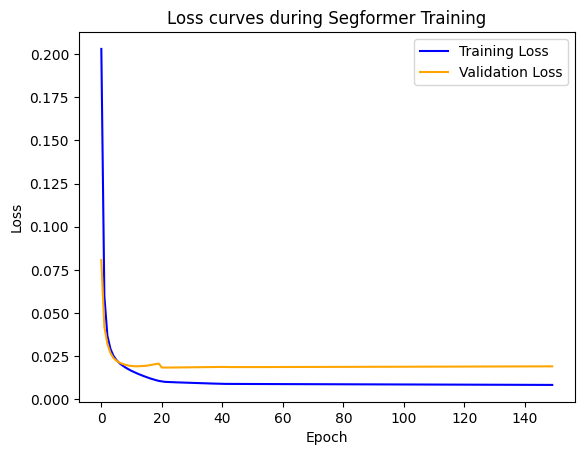

In [14]:
plt.plot(range(0, len(train_loss_avg)), train_loss_avg, label="Training Loss", color="blue")
plt.plot(range(0, len(val_loss_avg)), val_loss_avg, label="Validation Loss", color="orange")
plt.title("Loss curves during Segformer Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show();

In [15]:
model_name = 'segformer.pt'
torch.save(model, model_name)

In [11]:
model = torch.load(model_name)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [12]:
def calcDice(probs, mask):
	intersection = (probs * mask).sum()
	dice = (2. * intersection + 1) / (probs.sum() + mask.sum() + 1)

	return dice

def decodeSegformer(logits, mask=None):
	""" Decode the segformer model

	Args:
		logits (_type_): raw logits from segformer calculation
	"""

	upsampled_logits = F.interpolate(logits,
		size=image.size()[2:],
		mode='bilinear',
		align_corners=False)

	probs = torch.sigmoid(upsampled_logits)

	if mask is not None:
		dice = calcDice(probs, mask)
	else:
		dice = -1
	seg = np.round(probs)

	return seg, dice

In [13]:
import numpy as np
import pandas as pd
import time

def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

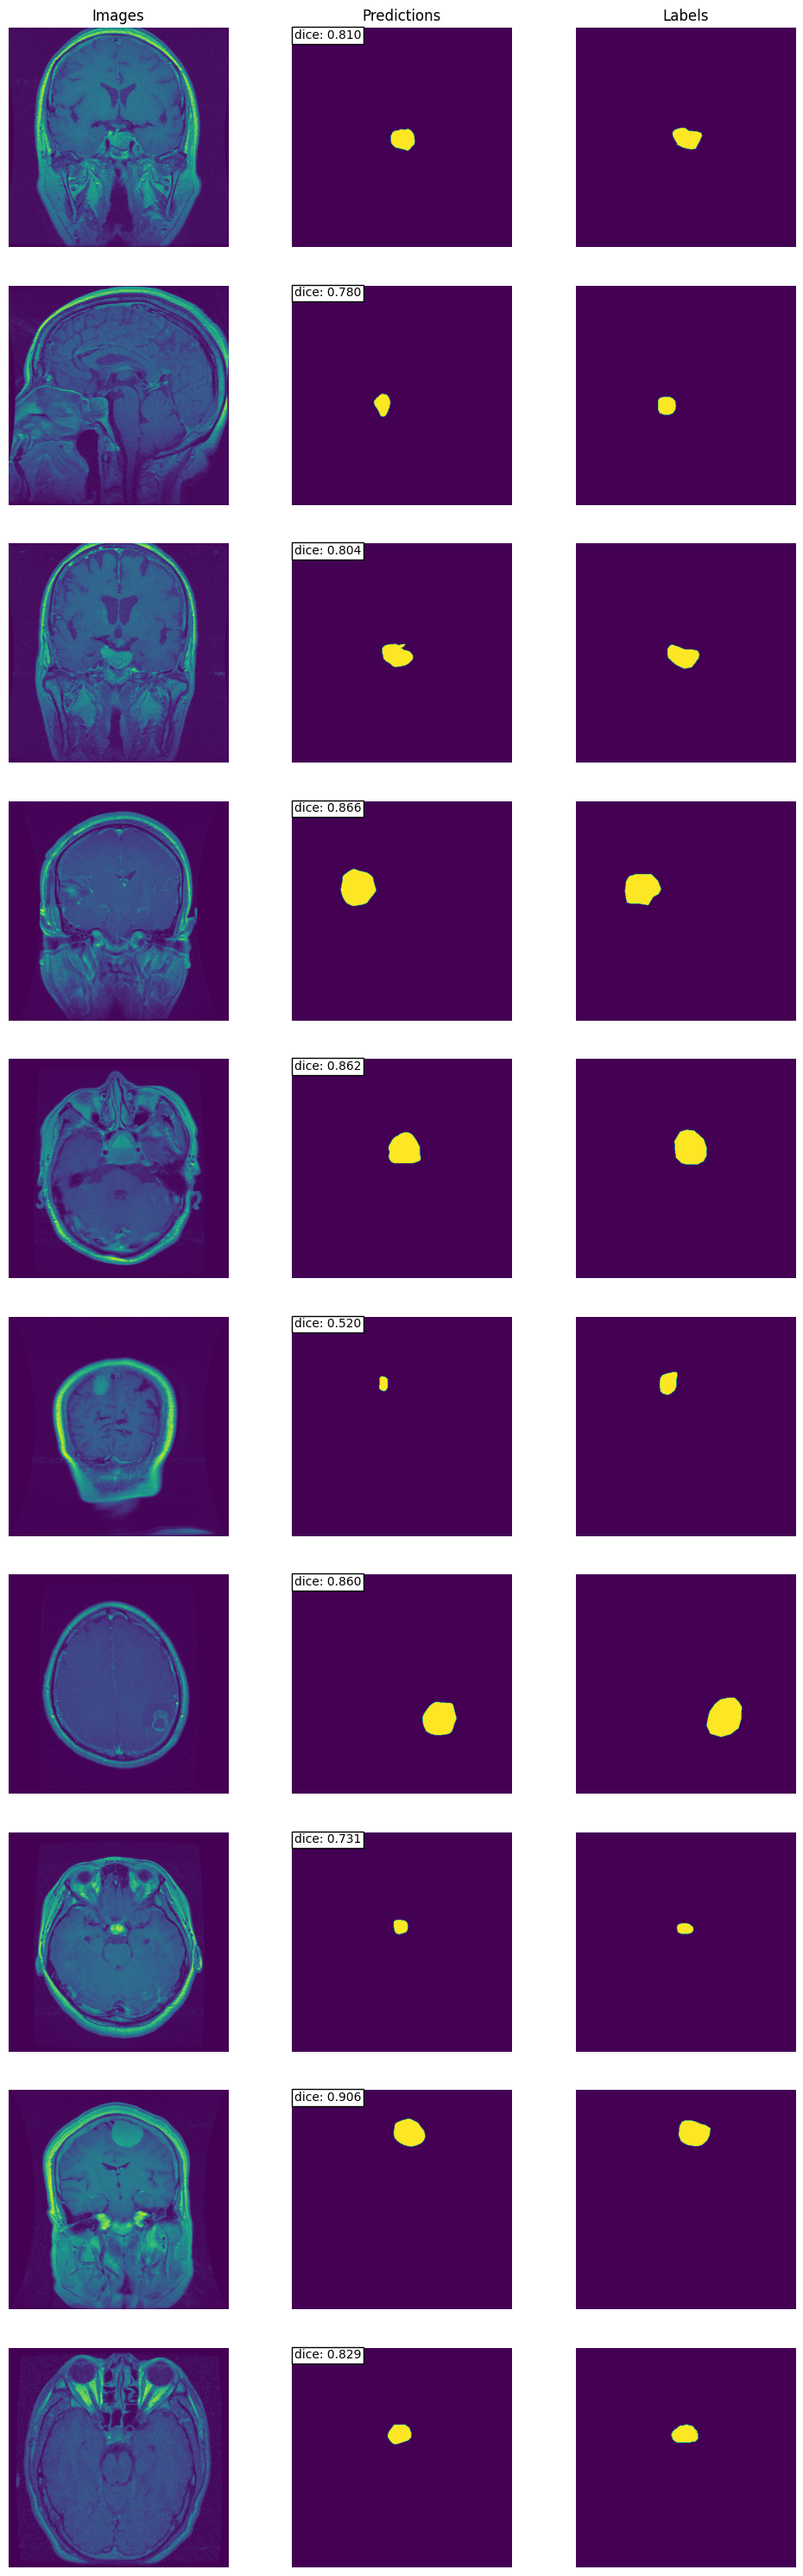

In [18]:
with torch.no_grad():

    model.eval()

    segs = []
    dices = []
    images = []
    masks = []

    # Get random indices for evaluating
    rng = np.random.default_rng()
    rands = rng.integers(low=0, high=valds.__len__(), size=10)        
    
    for i in rands:
        image, mask = valds.__getitem__(i)
        images.append(image)
        masks.append(mask)

    for image, mask in zip(images, masks):
        image = image.to(device)
        mask = mask.to(device)

        image = torch.unsqueeze(image, 0)
        mask = torch.unsqueeze(mask, 0)
        outputs = model(pixel_values=image, labels=mask)
        logits = outputs[0].cpu()
        mask = mask.cpu()

        seg, dice = decodeSegformer(logits, mask)

        dices.append(dice)
        segs.append(seg)

    # Convert images and labels back to device
    images = [x.cpu().numpy() for x in images]
    masks =  [x.cpu().numpy() for x in masks]

    # Show examples
    fig, ax = plt.subplots(10, 3, figsize=(10, 30))
    fig.tight_layout() # Make plot look better

    ax[0,0].set_title('Images')
    ax[0,1].set_title('Predictions')
    ax[0,2].set_title('Labels')

    for i in range(10):
        # Images
        ax[i, 0].imshow(images[i][0])
        ax[i, 0].axis('off')

        # Predictions
        ax[i, 1].imshow(np.squeeze(segs[i]))
        ax[i, 1].text(5, 25, f'dice: {dices[i].item():.3f}', bbox={'facecolor': 'white', 'pad': 2})
        ax[i, 1].axis('off')

        # Labels
        ax[i, 2].imshow(masks[i])
        ax[i, 2].axis('off')

    plt.show()


In [16]:
def calculateIoU(gtMask, predMask):
    tp = ((gtMask == 1) & (predMask == 1)).sum()
    fp = ((gtMask == 0) & (predMask == 1)).sum()
    fn = ((gtMask == 1) & (predMask == 0)).sum()

    iou = tp / (tp + fp + fn + 1e-6)  # Add small epsilon to avoid division by zero
    return iou

In [17]:
mean_iou = []

with torch.no_grad():
    model.eval()
    for images, masks in tqdm(test_loader):
        images = images.float().to(device)
        masks = masks.to(device)

        outputs = model(pixel_values=images)
        logits = outputs[0]

        upsampled_logits = F.interpolate(logits, size=masks.size()[1:], mode='bilinear', align_corners=False)
        pred_masks = torch.sigmoid(upsampled_logits) > 0.5
        pred_masks = pred_masks.cpu().numpy()

        gt_masks = masks.cpu().numpy()
        for gt_mask, pred_mask in zip(gt_masks, pred_masks):
            iou = calculateIoU(gt_mask, pred_mask)
            mean_iou.append(iou)

mean_iou_score = np.mean(mean_iou)
print(f"Mean IoU: {mean_iou_score:.4f}")

100%|██████████| 69/69 [00:08<00:00,  8.09it/s]

Mean IoU: 0.7382
